# Spike sorting and pre-processing e-phys data
 
The following notebook is meant to introduce kilosort spike-sorting using mEC data as a reference.

Here we will be performing basic sanity-checks and we'll also be getting to know the functions required for pre-processing data en-masse.

It is recommended to go through this notebook before processing all your data.

In [ ]:
## Setup block ##
import os 
import json
import pandas as pd
import numpy as np
from pathlib import Path
#for plotting cluster reports
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display 

CODE_DIRECTORY = '/ceph/behrens/peter_doohan/goalNav_mEC/experiment/code' #containing SpikeSorting folder
os.chdir(CODE_DIRECTORY)

#import probe interface

#import custom scripts
import SpikeSorting.spikesort_session as sps 
import SpikeSorting.optimise_kilosort as ok
import SpikeSorting.unit_matching as um

# For development:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data structure

We're expecting data which is structured as follows:
```Python
.
└── Experiment/ 
    ├── Code/ 
    │   └── ... <-- (you are somewhere here)
    └── Data/ 
        ├── ... 
        ├── raw_data/
        │   ├── ...
        │   └── ephys/
        │       └── [subject_ID]/
        │           └── [datetime]/
        │               └── [Open Ephys data]...
        └── preprocessed_data/
            ├── ...
            └── spikesorting
                └── [subject_ID]/
                    └── ...
```
One way to check that we're doing this is right is to generate a dataframe with all the path information required for preprocessing. This will also check that our files are readable (which can take a while). 

In [12]:
ephys_paths_df = sps.get_ephys_paths_df()
ephys_paths_df


subject_ID            datetime  \
0        mEC_2 2024-04-02 10:28:21   
1        mEC_2 2024-02-21 10:41:03   
2        mEC_2 2024-04-01 11:16:12   
3        mEC_2 2024-03-13 11:16:28   
4        mEC_2 2024-03-18 11:13:56   
..         ...                 ...   
706      mEC_8 2024-03-24 15:58:53   
707      mEC_8 2024-03-15 17:48:20   
708      mEC_8 2024-03-10 17:51:58   
709      mEC_8 2024-03-16 16:19:51   
710      mEC_8 2024-03-20 18:05:15   

                                           ephys_path  \
0    ../data/raw_data/ephys/mEC_2/2024-04-02_10-28-21   
1    ../data/raw_data/ephys/mEC_2/2024-02-21_10-41-03   
2    ../data/raw_data/ephys/mEC_2/2024-04-01_11-16-12   
3    ../data/raw_data/ephys/mEC_2/2024-03-13_11-16-28   
4    ../data/raw_data/ephys/mEC_2/2024-03-18_11-13-56   
..                                                ...   
706  ../data/raw_data/ephys/mEC_8/2024-03-24_15-58-53   
707  ../data/raw_data/ephys/mEC_8/2024-03-15_17-48-20   
708  ../data/raw_data/ephys/mEC_8/2024-03-10_17-51-58   
709  ../data/raw_data/ephys/mEC_8/2024-03-16_16-19-51   
710  ../data/raw_data/ephys/mEC_8/2024-03-20_18-05-15   

     spike_sorting_completed  spike_interface_readable  duration_min  
0                       True                      True     40.232016  
1                       True                      True     40.730847  
2                       True                      True     40.145527  
3                       True                      True     30.223200  
4                       True                      True     30.030300  
..                       ...                       ...           ...  
706                     True                      True     40.091060  
707                     True                      True     30.046680  
708                     True                      True     40.318593  
709                     True                      True     30.072467  
710                     True                      True     20.118707  

[711 rows x 6 columns]

In [13]:
## Quick check of how many files were readable
n_readable = sum(ephys_paths_df['spike_interface_readable']==True)
print(f'{n_readable} out of {len(ephys_paths_df)} files are readable ({round(n_readable/len(ephys_paths_df)*100,2)}%)')

666 out of 711 files are readable (93.67%)


In [ ]:
#Beware: the following lines of code will submit all sessions to be processed on the cluster.
#import SpikeSorting.run_ephys_preprocessing as run_e
#run_e.run_ephys_preprocessing()

In [ ]:
# Example query to look for failed jobs
df = sps.get_ephys_paths_df()
incomplete_df = df.query('spike_interface_readable==True and spike_sorting_completed == False and duration_min>8')

incomplete_df

subject_ID            datetime  \
89       mEC_2 2024-03-19 11:44:24   
143      mEC_2 2024-03-14 10:24:28   
145      mEC_7 2024-03-16 13:53:06   
151      mEC_7 2024-03-13 14:35:34   
228      mEC_7 2024-02-17 16:20:51   
426      mEC_6 2024-02-17 14:59:05   
517      mEC_5 2024-03-28 12:00:33   
550      mEC_5 2024-03-27 11:39:44   

                                           ephys_path  \
89   ../data/raw_data/ephys/mEC_2/2024-03-19_11-44-24   
143  ../data/raw_data/ephys/mEC_2/2024-03-14_10-24-28   
145  ../data/raw_data/ephys/mEC_7/2024-03-16_13-53-06   
151  ../data/raw_data/ephys/mEC_7/2024-03-13_14-35-34   
228  ../data/raw_data/ephys/mEC_7/2024-02-17_16-20-51   
426  ../data/raw_data/ephys/mEC_6/2024-02-17_14-59-05   
517  ../data/raw_data/ephys/mEC_5/2024-03-28_12-00-33   
550  ../data/raw_data/ephys/mEC_5/2024-03-27_11-39-44   

     spike_sorting_completed  spike_interface_readable  duration_min  
89                     False                      True     28.382722  
143                    False                      True     40.058020  
145                    False                      True     30.071193  
151                    False                      True     30.459613  
228                    False                      True     10.909787  
426                    False                      True     10.729027  
517                    False                      True     30.090187  
550                    False                      True     30.277260

## 2. Probe channel assignments



A first step for pre-processing is identifying which channels of the probe may lie outside of the brain.
This is done by rough filtering of the data according to a parameter 'outside_thresh', which should be double-checked against the first and last session of each mouse for consistency across recordings.

Run the blocks below for each subject until the plotted outputs look reasonable. 
Since the channels outside the brain may shift slightly throughout long chronic sessions, here we choose a set of parameters that looks reasonable for the **first** and **last** session, which should identify channels outside the brain across all days.

In [14]:
# CHECK first_last_df #

# Load dataframe with info on first and last sessions per mouse
first_last_df = sps.get_first_last_df(min_duration_min=30) #option to filter for minimum duration
first_last_df

subject_ID            datetime  \
60       mEC_2 2024-02-20 10:38:18   
118      mEC_2 2024-04-15 09:46:33   
480      mEC_5 2024-02-20 10:38:18   
471      mEC_5 2024-04-15 10:31:24   
365      mEC_6 2024-02-20 13:33:48   
292      mEC_6 2024-04-15 12:28:51   
224      mEC_7 2024-02-20 13:33:48   
233      mEC_7 2024-04-15 13:14:59   
607      mEC_8 2024-02-20 15:37:33   
597      mEC_8 2024-04-15 15:14:23   

                                           ephys_path  \
60   ../data/raw_data/ephys/mEC_2/2024-02-20_10-38-18   
118  ../data/raw_data/ephys/mEC_2/2024-04-15_09-46-33   
480  ../data/raw_data/ephys/mEC_5/2024-02-20_10-38-18   
471  ../data/raw_data/ephys/mEC_5/2024-04-15_10-31-24   
365  ../data/raw_data/ephys/mEC_6/2024-02-20_13-33-48   
292  ../data/raw_data/ephys/mEC_6/2024-04-15_12-28-51   
224  ../data/raw_data/ephys/mEC_7/2024-02-20_13-33-48   
233  ../data/raw_data/ephys/mEC_7/2024-04-15_13-14-59   
607  ../data/raw_data/ephys/mEC_8/2024-02-20_15-37-33   
597  ../data/raw_data/ephys/mEC_8/2024-04-15_15-14-23   

     spike_sorting_completed  spike_interface_readable  duration_min  \
60                      True                      True     40.675807   
118                     True                      True     40.142347   
480                     True                      True     40.675773   
471                     True                      True     40.088076   
365                     True                      True     40.181927   
292                     True                      True     40.527193   
224                     True                      True     40.181413   
233                     True                      True     40.257344   
607                     True                      True     40.166780   
597                     True                      True     40.118420   

           date  
60   2024-02-20  
118  2024-04-15  
480  2024-02-20  
471  2024-04-15  
365  2024-02-20  
292  2024-04-15  
224  2024-02-20  
233  2024-04-15  
607  2024-02-20  
597  2024-04-15

Choosing mEC_2 from: ['mEC_2' 'mEC_5' 'mEC_6' 'mEC_7' 'mEC_8']
Succesfully retrieved probe from recording
Saved out probe data to 
 ../data/preprocessed_data/spikesorting/probe_params/mEC_2


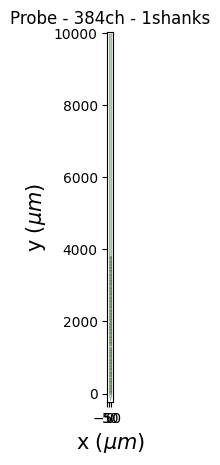

In [15]:
# CHECK PROBE SETUP # 
# Here we make sure that probes have the correct information per subject
# Probe information is saved in .../preprocessed_data/probe_params/subject/

# Load dataframe with info on first and last sessions per mouse
subject_IDs = first_last_df['subject_ID'].unique()

# CHOOSE YOUR SUBJECT    ⬇
subject_ID = subject_IDs[0]
print(f'Choosing {subject_ID} from: {subject_IDs}')

sps.save_rec_probe(subject_ID,
                        manufacturer = 'cambridgeneurotech',
                        probe_name = 'ASSY-236-F',
                        wiring_device='cambridgeneurotech_mini-amp-64',
                        probe_suffix = None, #'probe_A', 'probe_B' if multiple probes; do this once for each probe, for each subject
                        manual_ephys_path=None) #should handle things automatically, but included here for debugging.

Assigning channels for mEC_6
Successfully extracted probe from recording.
Assigning bad channels...


No outside_brain channels found on shank 1
No noisey channels found on shank 1
1 dead channel(s) found on shank 1
Successfully extracted probe from recording.
Assigning bad channels...
16 outside_brain channel(s) found on shank 1
No noisey channels found on shank 1
15 dead channel(s) found on shank 1


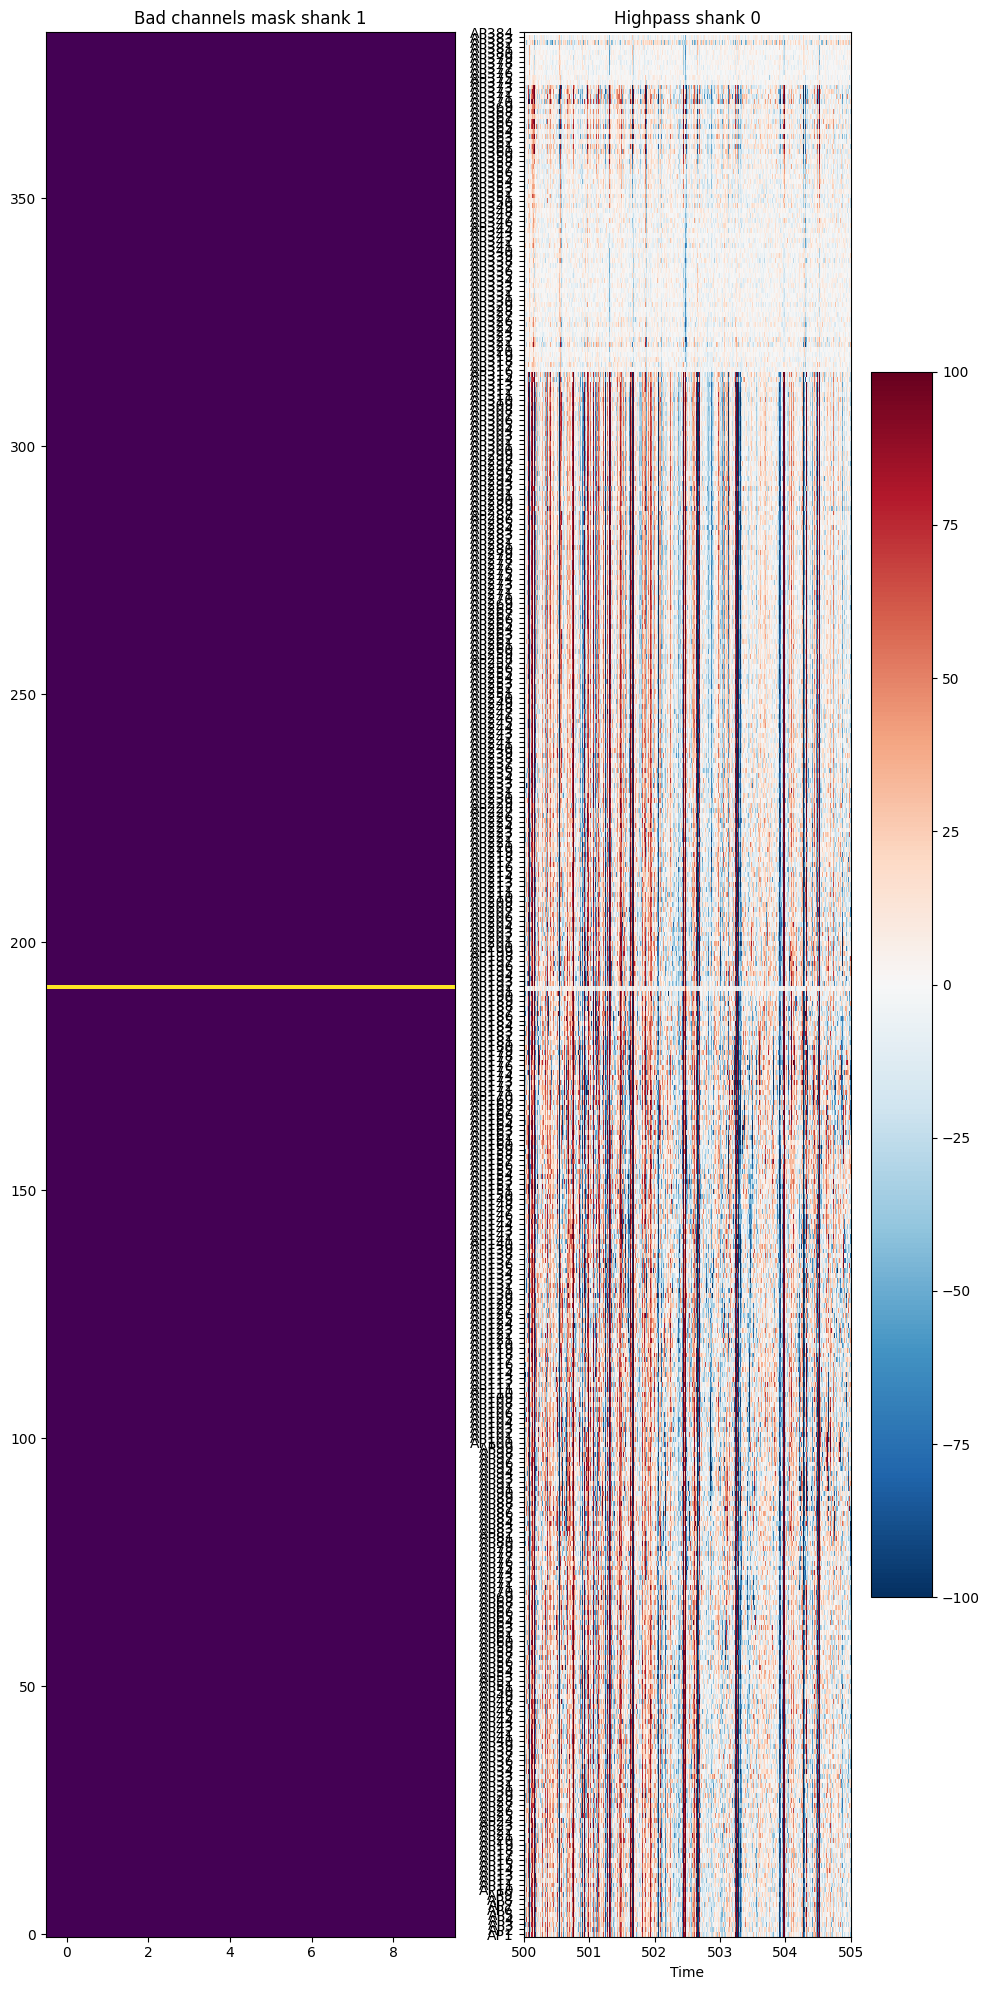

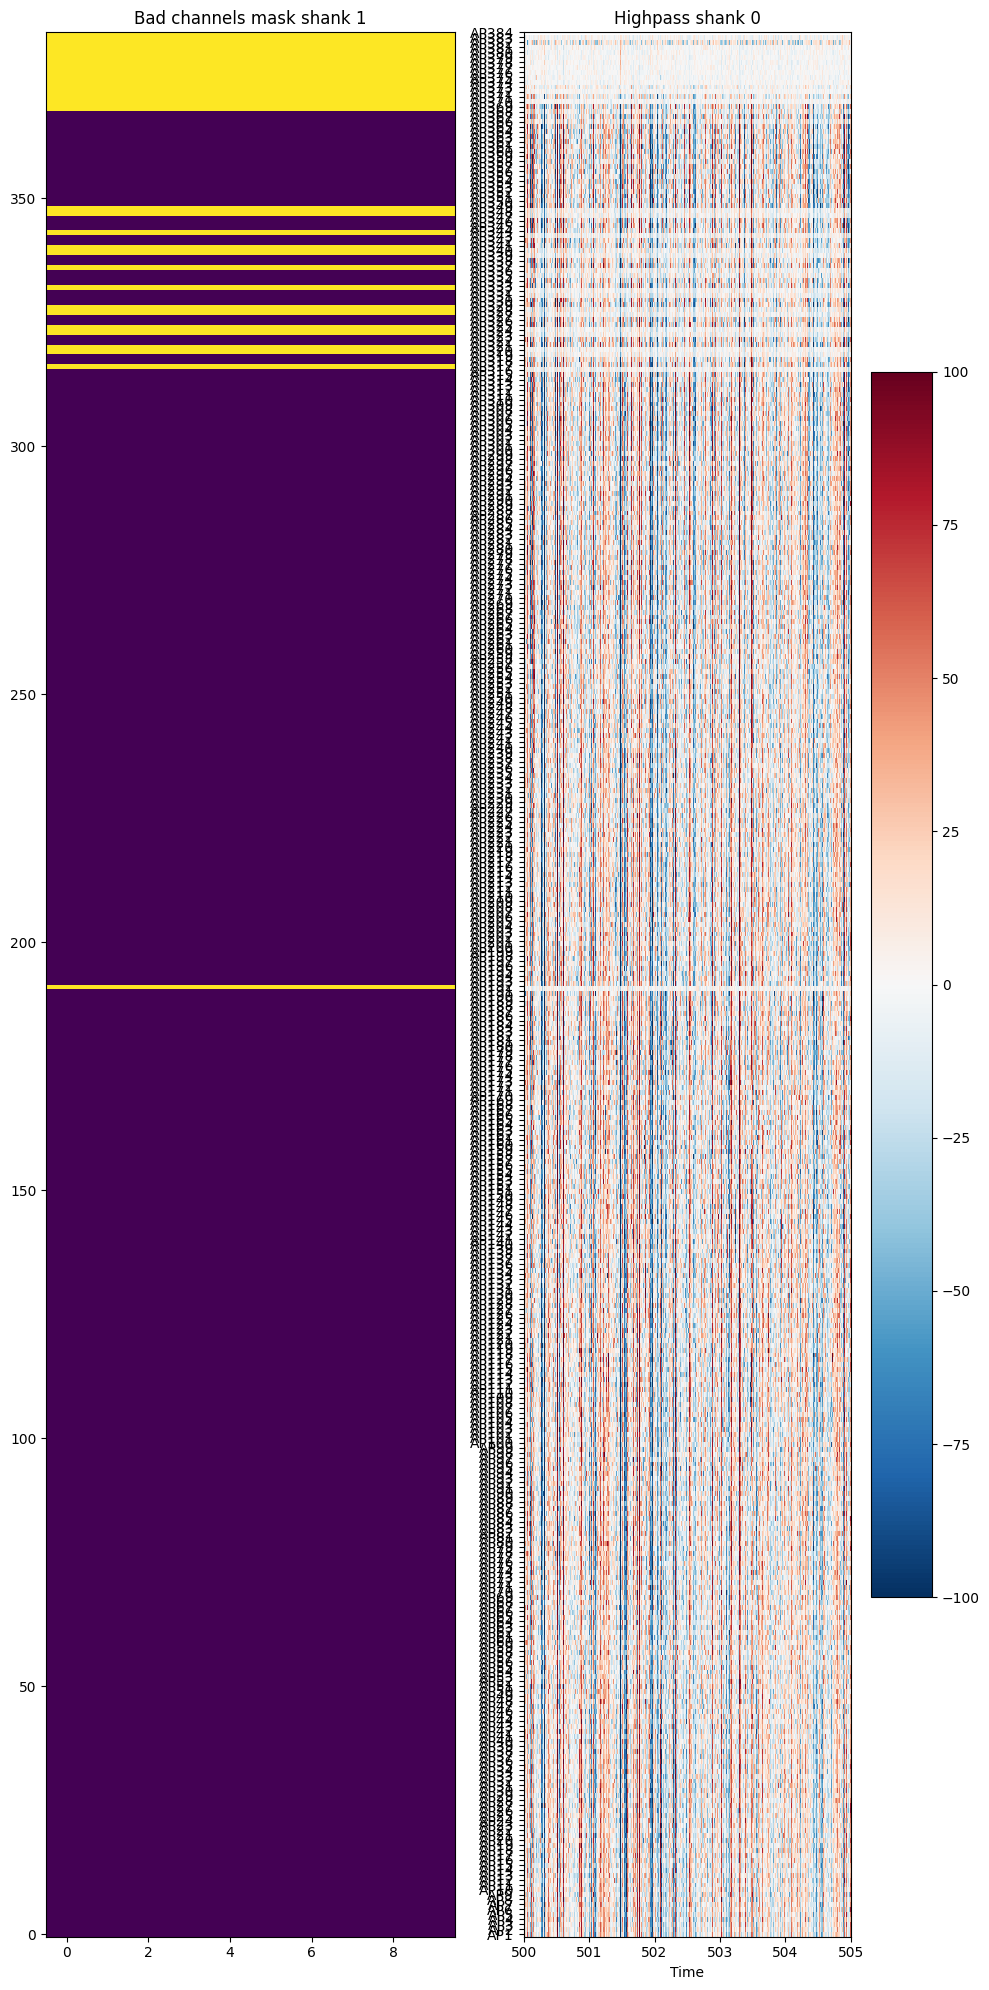

In [ ]:
# DETECT BAD CHANNELS / OUTSIDE BRAIN CHANNELS 
# SET THRESHOLD     ⬇   
outside_thresh = -0.15 #Default is -0.75, but try values between +/-0.7 in increments >= 0.05. 
n_neighbours = 37 #Default is 11, must be an odd number. If there's a missing chunk, take at least twice the missing chunk size for nyquist.

# CHOOSE YOUR SUBJECT                             ⬇
subject_ID = first_last_df['subject_ID'].unique()[2]
print(f'Assigning channels for {subject_ID}')

sps.save_channel_assignment_params(subject_ID, outside_thresh, n_neighbours,
                                    probe_suffix = None) # specify 'probe_A' or 'probe_B' if there are multiple probes for a subject
  

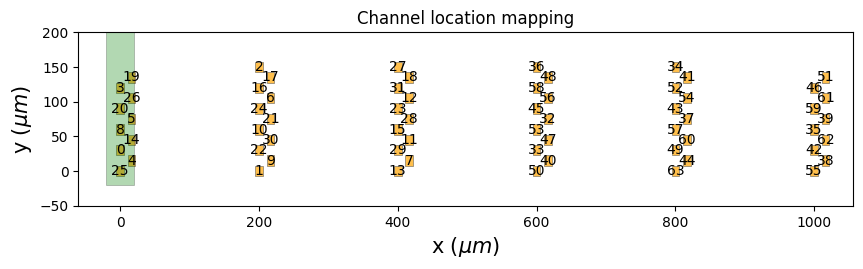

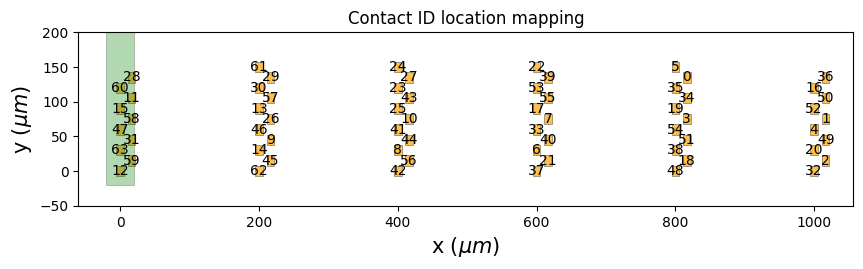

In [ ]:
## SANITY CHECK ON PROBE MAPPING
#This codeblock may be useful for cambridge neurotech probes 
import spikeinterface.extractors as se
import spikeinterface.full as si
from probeinterface import Probe

recording, sorting_true = se.toy_example(num_channels=64, duration=5, seed=0)

#loading a saved out cambridge neurotech probe
probe_params_path = Path('/ceph/behrens/peter_doohan/goalNav_mEC/experiment/data/preprocessed_data/spikesorting/probe_params/mEC_2/probe_A')
probe_df = pd.read_csv(probe_params_path/'probe_layout.tsv')
probe_obj = Probe.from_dataframe(probe_df)

recording = recording.set_probe(probe_obj)
fig, ax = plt.subplots(figsize=(10,15))
si.plot_probe_map(recording, with_channel_ids=True, ax= ax)
ax.set(ylim=(-50,200), title='Channel location mapping')
plt.show()

probe_obj.device_channel_indices = np.arange(64) #ignore channel mapping

recording = recording.set_probe(probe_obj)
fig, ax = plt.subplots(figsize=(10,15))
si.plot_probe_map(recording, with_channel_ids=True, ax= ax)
ax.set(ylim=(-50,200), title='Contact ID location mapping')
plt.show()

## 3 IBL pre-processing



Below we take a closer look at the pre-processing steps taken according IBL standard.
We use a 1ms snippet of data and show each step. 

1. highpass (low-cut) filter (Butterworth 3rd order)
2. temporal alignment with sampling delay across channels
3. spatial filter for 'Destriping'

Note that these steps are performed after interpolating bad channels. After this stage the data is then sent to kilosort for spike detection.

Successfully extracted probe from recording.
Assigning bad channels...
No outside_brain channels found on shank 1
4 noisey channel(s) found on shank 1
4 dead channel(s) found on shank 1
saving preprocessed traces for visual inspection


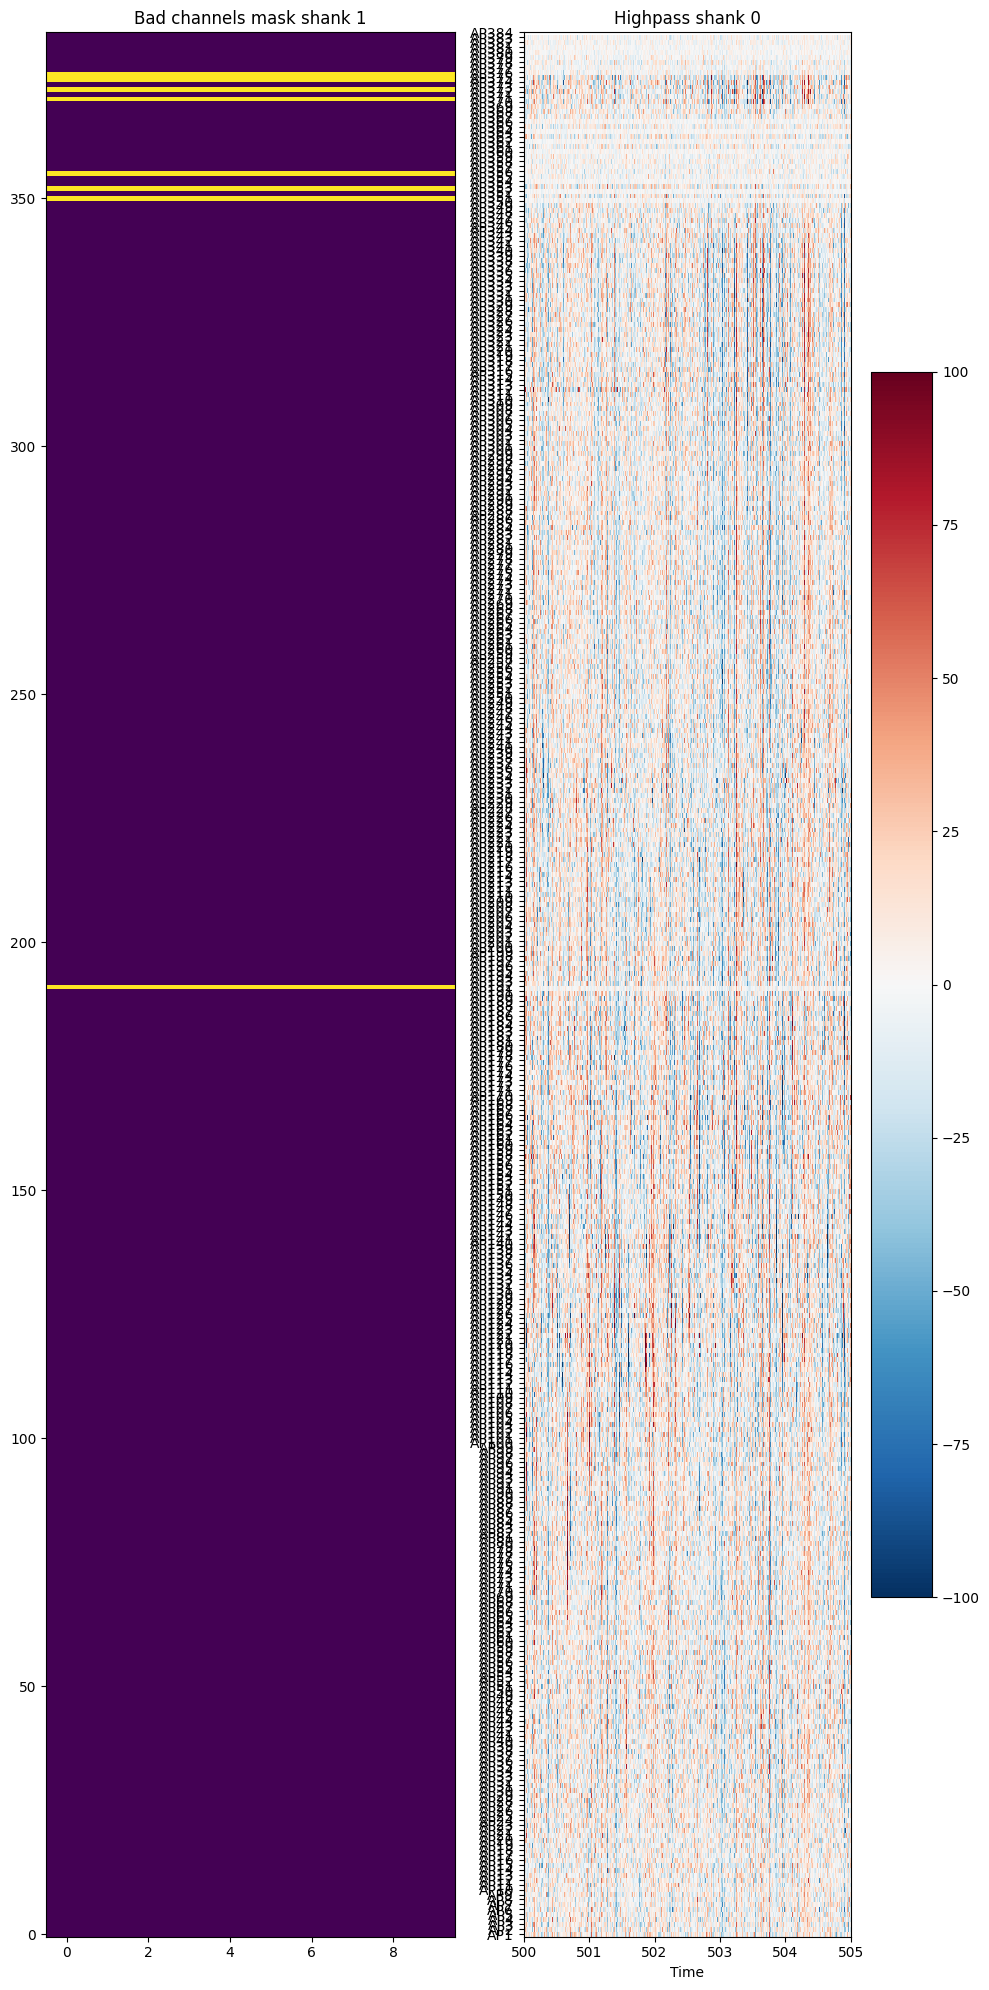

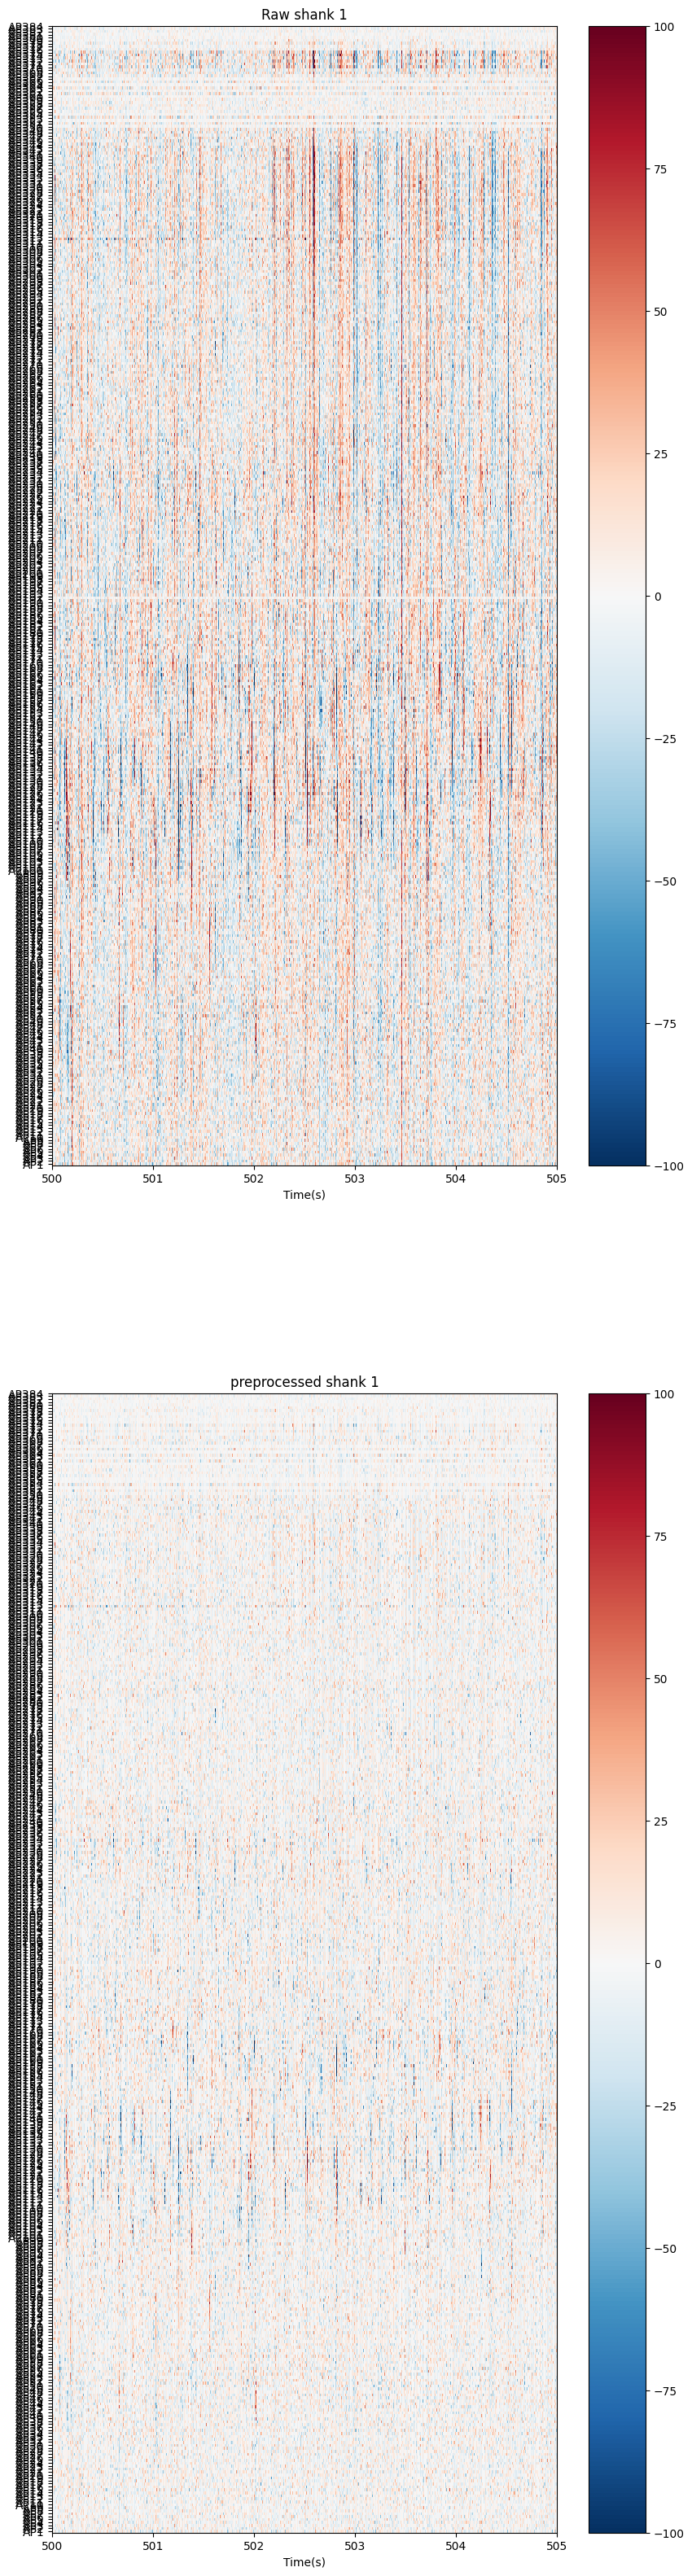

In [35]:
# EXAMPLE OF IBL PREPROCESSING

first_last_df = sps.get_first_last_df()
ephys_info = first_last_df.iloc[0]

raw_recs, preprocessed_paths = sps.get_probe_recordings(ephys_info.subject_ID,
                                                        ephys_info.datetime.isoformat(),
                                                        ephys_info.ephys_path)
for raw_rec, preprocessed_path in zip(raw_recs,preprocessed_paths):
    preprocessed_rec = sps.pre_kilosort_processing(raw_rec, preprocessed_path, IBL_preprocessing = True)


Successfully extracted probe from recording.
Assigning bad channels...
68 outside_brain channel(s) found on shank 1
No noisey channels found on shank 1
3 dead channel(s) found on shank 1


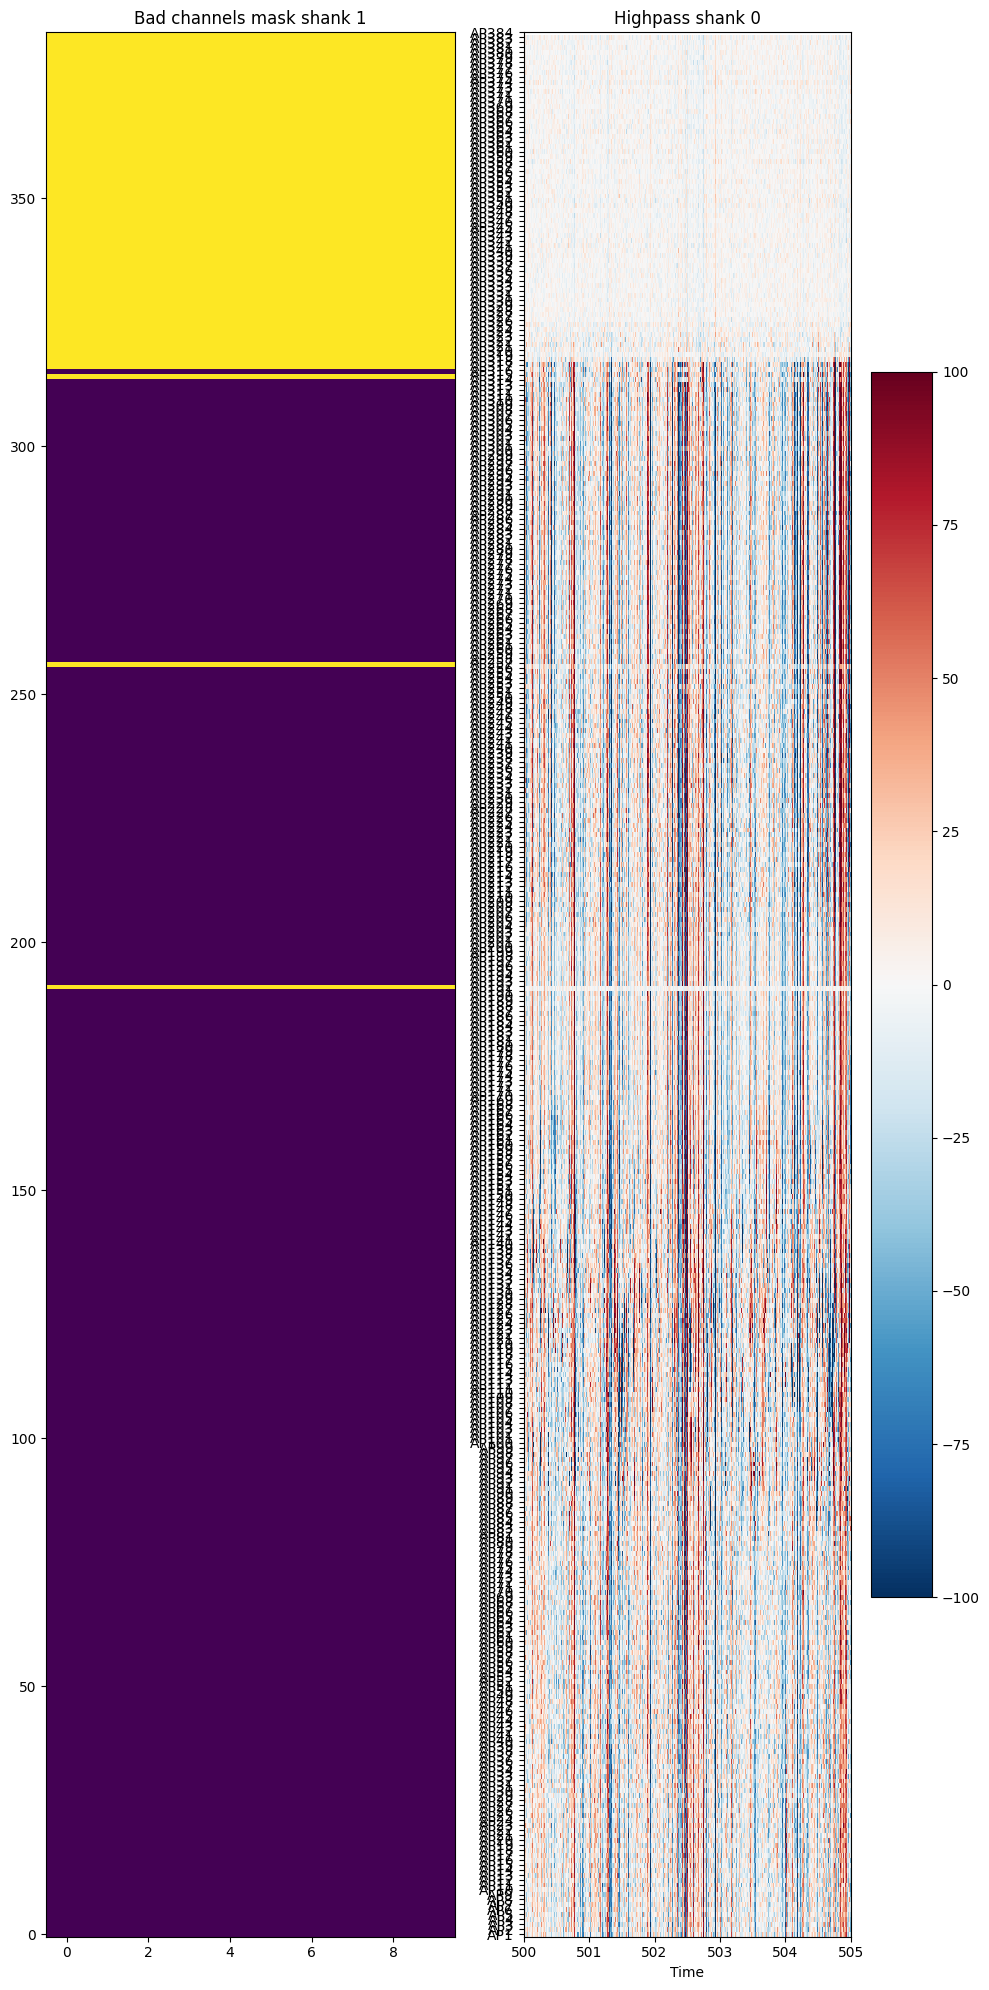

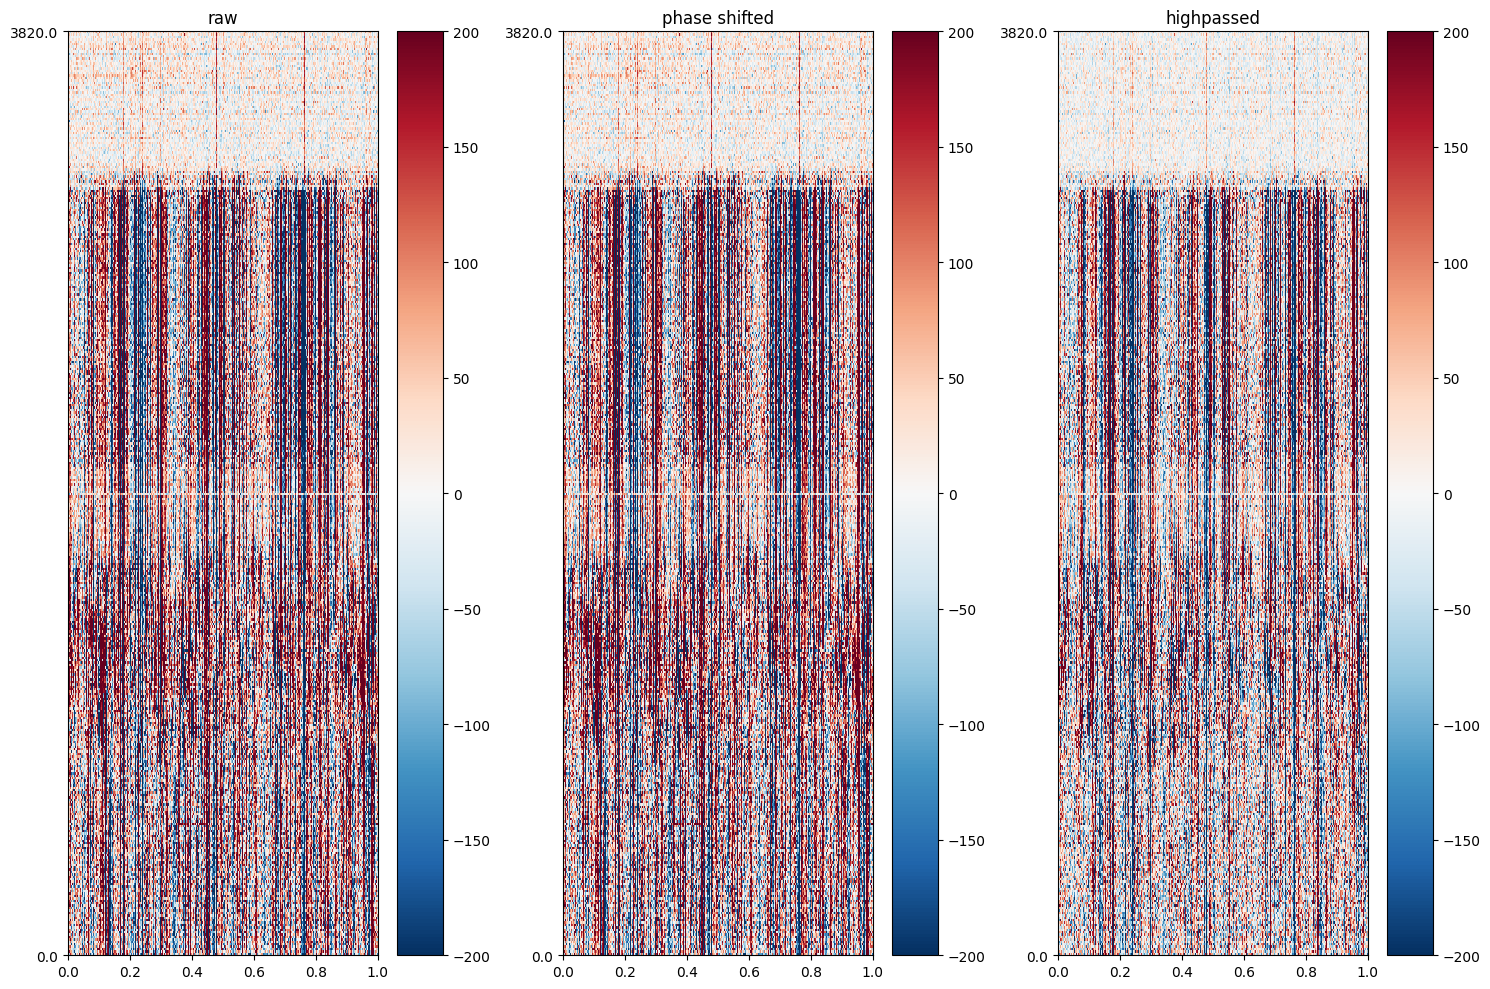

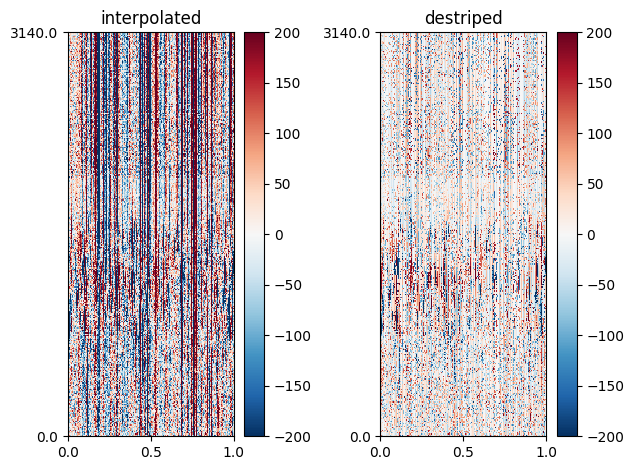

In [ ]:
# DETAILED IBL preprocessing #
#unpacking sps.pre_kilosort_processing(raw_rec, preprocessed_path, IBL_preprocessing = True)

# import a few spikeinterface modules
import spikeinterface.full as si
from spikeinterface import extractors as se
from spikeinterface import preprocessing as sp
from spikeinterface import widgets as sw

first_last_df = sps.get_first_last_df()
ephys_info = first_last_df.iloc[0]

raw_recs, preprocessed_paths = sps.get_probe_recordings(ephys_info.subject_ID,
                                                        ephys_info.datetime.isoformat(),
                                                        ephys_info.ephys_path)

raw_rec = raw_recs[0]
preprocessed_path = preprocessed_paths[0]

# keep a very short recording snippet for quick on-demand processing
fs = raw_rec.sampling_frequency
length_in_seconds = 60
snippet = raw_rec.frame_slice(start_frame=int(fs * length_in_seconds), end_frame=int(fs * length_in_seconds*2))


#unpacking sps.pre_kilosort_processing(raw_rec, preprocessed_path, IBL_preprocessing = True)

#remove outside brain channels and interpolate bad channels
channel_assignments = sps.get_channel_assignments(raw_rec, preprocessed_path) #NB: the input is raw recording here
    ##From here on we preprocess data per shank
n_shanks = len(np.unique(raw_rec.get_property('group')))
split_recordings = snippet.split_by(property='group')
preprocessed_recs = [] #for later merging of recordings
for each_shank in range(n_shanks): 
    raw_shank = split_recordings[each_shank]
    shank_channels = raw_shank.get_channel_ids()
    #phase shift
    if raw_shank.get_property('inter_shift_sample')!=None:
        phase_shifted_shank = sp.phase_shift(raw_shank)
    else:
        phase_shifted_shank = raw_shank
        #high pass filter
    highpassed_shank = sp.highpass_filter(phase_shifted_shank)
    
    outside_brain_channels = [k for k, v in channel_assignments.items() if k in shank_channels and v == "out"]
    if len(outside_brain_channels) > 0:
        removed_shank = highpassed_shank.remove_channels(outside_brain_channels)
    else:
        outside_brain_channels = None
        removed_shank = highpassed_shank #no change
    bad_channels = [k for k, v in channel_assignments.items() if k in shank_channels and v in ["noise", "dead",]]
    if len(bad_channels) > 0:
        interpolated_shank = sp.interpolate_bad_channels(removed_shank, bad_channel_ids=bad_channels)
    else:
        interpolated_shank = removed_shank #no change
    # destripe (denoising)
    n_channels_on_shank = len(interpolated_shank.get_property('group'))
    n_channel_pad=min(60,n_channels_on_shank)
    destriped_shank = sp.highpass_spatial_filter(interpolated_shank, n_channel_pad=n_channel_pad)
    preprocessed_recs.append(destriped_shank)
    
preprocessed_rec = si.aggregate_channels(preprocessed_recs)

## PLOTTING ##

# First figure with basic preprocessing for the last shank
fig, axs = plt.subplots(ncols=3, figsize = (15,10))
sw.plot_traces(raw_shank, ax=axs[0])
sw.plot_traces(phase_shifted_shank, ax=axs[1])
sw.plot_traces(highpassed_shank, ax=axs[2])
for i,titles in enumerate(['raw','phase shifted','highpassed']):
    axs[i].set(title=f'{titles}')
fig.tight_layout()
plt.show()

#Second figure after removing bad channels:
fig, axs = plt.subplots(ncols=2)
sw.plot_traces(interpolated_shank,ax=axs[0])
axs[0].set(title='interpolated')

sw.plot_traces(destriped_shank,ax=axs[1])
axs[1].set(title='destriped')

fig.tight_layout()

### 3.1 Advantages over default kilosort preprocessing

We want a quick sanity check on the advantages of using this preprocessing over standard kilosort preprocessing (all parameters default).

This is done more robustly in optimise_kilosort.py

Assigning bad channels...
68 outside_brain channel(s) found on shank 1
No noisey channels found on shank 1
3 dead channel(s) found on shank 1


/nfs/nhome/live/cburns/.conda/envs/maze_ephys/lib/python3.12/site-packages/spikeinterface/widgets/traces.py:147: UserWarning: You have selected a time after the end of the segment. The range will be clipped to 60.0
  warnings.warn(
/nfs/nhome/live/cburns/.conda/envs/maze_ephys/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/nfs/nhome/live/cburns/.conda/envs/maze_ephys/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/nfs/nhome/live/cburns/.conda/envs/maze_ephys/lib/python3.12/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


ValueError: zero-size array to reduction operation maximum which has no identity

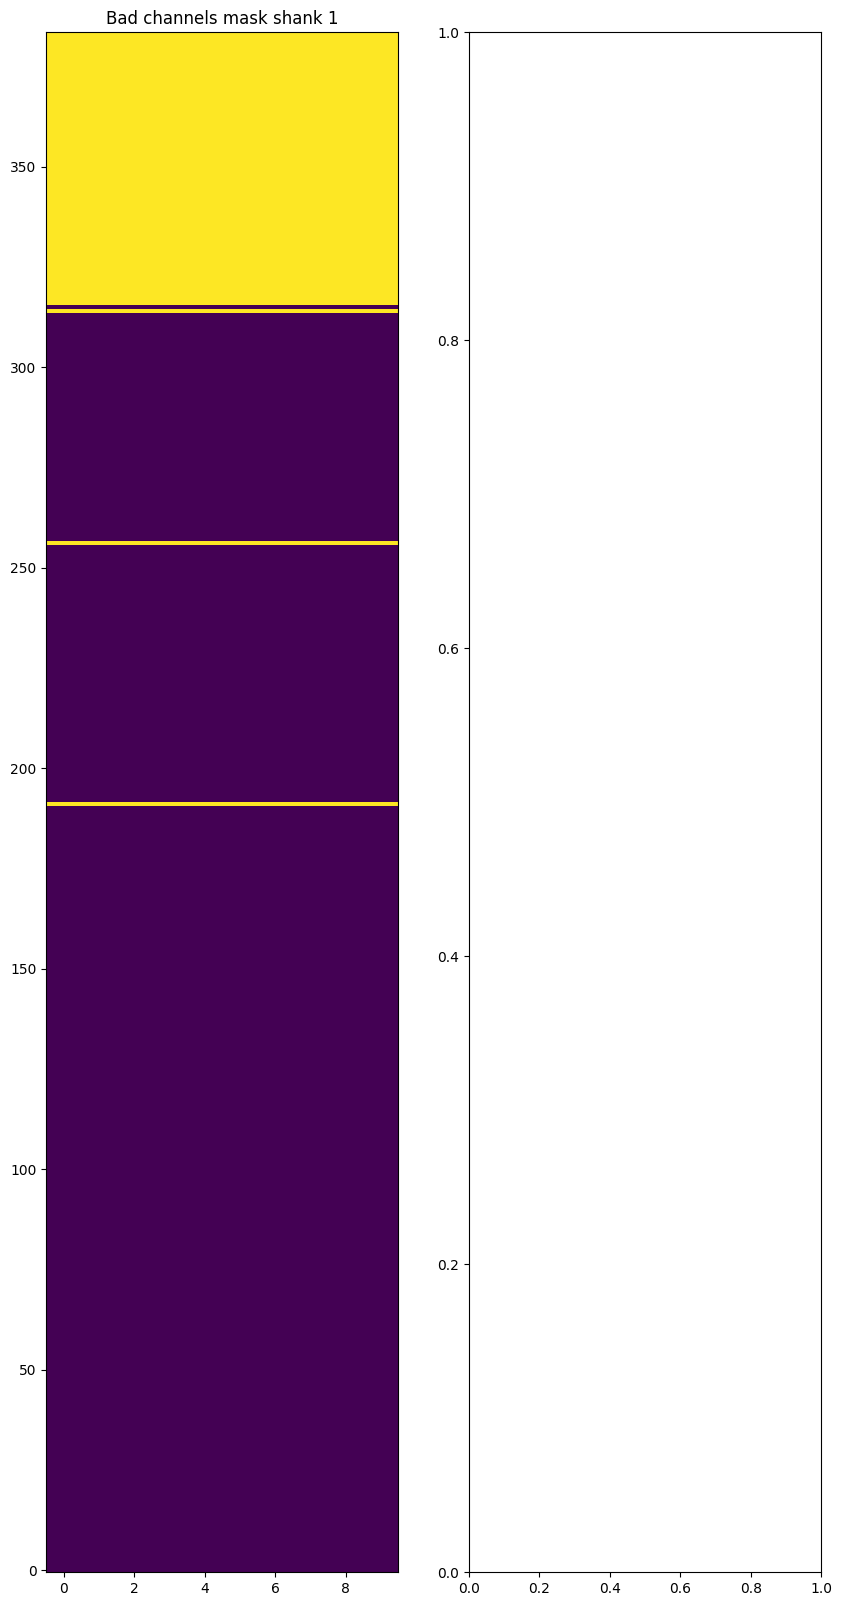

In [ ]:
# Example of spikesorting with and without IBL preprocessing

#NB here we inherit snippet and preprocessed_path from detailed IBL preprocessing block

ibl_preprocessed = sps.pre_kilosort_processing(snippet, preprocessed_path, IBL_preprocessing = True)

ibl_pre_sorted = sps.run_kilosort4(ibl_preprocessed, preprocessed_path, IBL_preprocessing = True)
sip_IBL_sorted = sps.run_kilosort4(snippet, preprocessed_path, IBL_preprocessing = False)


## 4. Optimising kilosort



Once we've assigned our channels, we are ready to denoise our data and run kilosort.

This is done at the session level with a single function.

There are two parameters which are worth tuning according to Kilosort4 docs: Th_universal and Th_learned.
These set the thresholds for inclusion of spikes later used to learn templates. 

- lowering these thresholds includes more data as putative spikes when finding waveform templates
- but this may also run the risk of including more noise, therefore favouring higher thresholds.

We therefore run kilosort with a small range of parameters and compare differences here.


In [ ]:
#Run kilosort on the first and last session across
import SpikeSorting.optimise_kilosort as ok
ok.submit_jobs()

In [ ]:
#Then after the cluster is finished letting it rip, you can summarise the results
ok.summarise_results()

The first plot should give an indication of what parameters give us most units. 

Top row is for kilosort 'good' units and second row is for units which pass the IBL criteria for 'single units'.

To make sure that these units are not being selected under some biases, we plot the distributions of quality metrics.
We do this for for first session (top row) and last session (bottom row).

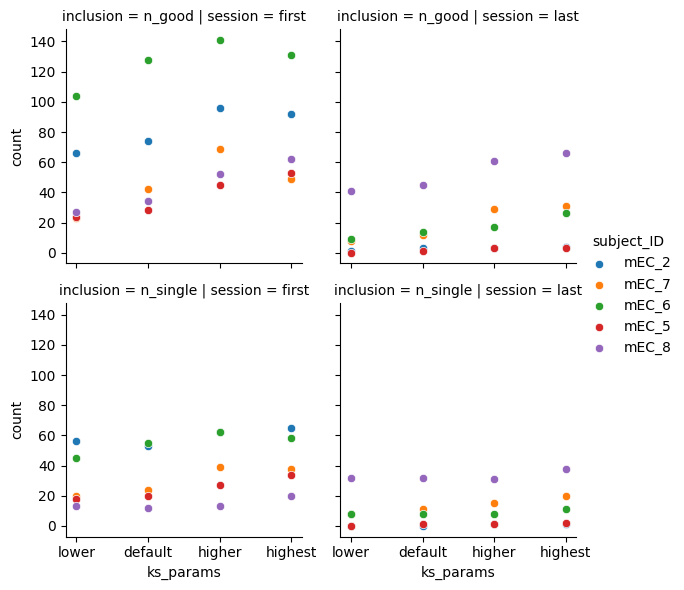

In [ ]:
optim_df = ok.get_optim_df()

optim_df['subject_ID'] = optim_df['session_path'].apply(lambda x: x.parts[-2])
optim_df['session'] = optim_df['session_path'].apply(lambda x: 'first' if x.parts[-1][:7]=='2024-02' else 'last')

n_good = []
n_single = []
for each_session in optim_df['session_path']:
    ks_labels = sps.pd.read_csv(each_session/'kilosort4'/'sorter_output'/'cluster_KSLabel.tsv', sep='\t')
    good_clusters = ks_labels[ks_labels.KSLabel=='good']
    n_good.append(len(good_clusters))
    qual_df = sps.pd.read_csv(each_session/'quality_metrics.htsv', sep='\t')
    single_units = sps.get_single_units(qual_df)
    n_single.append(len(single_units))

optim_df['n_good'] = n_good
optim_df['n_single'] = n_single
plot_df = optim_df.melt(id_vars=['session_path','ks_params','subject_ID','session'],
            value_vars=['n_good','n_single'], var_name='inclusion', value_name='count')

import seaborn as sns
g = sns.FacetGrid(plot_df, col='session', row='inclusion', hue='subject_ID')
g.map(sns.scatterplot, "ks_params", "count")
g.add_legend()


### 4.1 cluster reports

### Excluded units ('good' but not 'single')

In [ ]:
# Look at an example session cluster metric and kilosort labels. 
session_path = optim_df.iloc[5].session_path
cluster_metrics_df = sps.pd.read_csv((session_path/'quality_metrics.htsv'), sep='\t')
single_units = sps.get_single_units(cluster_metrics_df)

ks_labels = sps.pd.read_csv(session_path/'kilosort4'/'sorter_output'/'cluster_KSLabel.tsv', sep='\t')
good_clusters = ks_labels[ks_labels.KSLabel=='good']
excluded_clusters = list(set(good_clusters['cluster_id'])-set(single_units))

print(f'{len(good_clusters)} good clusters, {len(excluded_clusters)} of which are excluded and plotted below:')
for each_cluster in excluded_clusters:
    display(Image(session_path/'cluster_reports'/'units'/f'{each_cluster}.png'))

### Single units

In [ ]:
## Plotting 'single' units
# Look at an example session cluster metric and kilosort labels. 
session_path = optim_df.iloc[39].session_path
cluster_metrics_df = sps.pd.read_csv((session_path/'quality_metrics.htsv'), sep='\t')
single_units = sps.get_single_units(cluster_metrics_df)

ks_labels = sps.pd.read_csv(session_path/'kilosort4'/'sorter_output'/'cluster_KSLabel.tsv', sep='\t')
good_clusters = ks_labels[ks_labels.KSLabel=='good']
excluded_clusters = list(set(good_clusters['cluster_id'])-set(single_units))

print(f'{len(single_units)} single units plotted below:')
for each_cluster in single_units:
    display(Image(session_path/'cluster_reports'/'units'/f'{each_cluster}.png'))

## 5. Identifying cells across sessions

UNDER DEVELOPMENT


One of the primary aims is to identify and track grid-cell representations on the maze.
This requires identifying the possible pairs across sessions.

In [ ]:
#First we identify all the sessions of a subject that have been kilosorted:
subject_pairs_df = um.get_pairs_df(subject='mEC_5')


In [ ]:
import SpikeSorting.unit_matching as pre_um

pair = subject_pairs_df.iloc[0]
print(f"Matching sessions {pair['datetimes']}")
UM_out_path = Path(pair['UM_out_path'])
UM_out_path.mkdir(parents=True,exist_ok=True)
for preprocessed_path in pair['preprocessed_paths']:
    sps.save_unitmatch_labels(preprocessed_path)
    pre_um.pad_UM_inputs(preprocessed_path)
pre_um.unit_match_sessions(pair['UM_input_paths'])
pre_um.get_unitmatch_reports(pair)
    

### Debugging UnitMatch

In [ ]:
##DEBUGGING

import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.save_utils as su
import UnitMatchPy.GUI as gui
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy.default_params as default_params

#query = mec2_df.query('completed_UM == False').iloc[1]
subject = 'mEC_2'
datetime1 = failed_df.iloc[idx].datetime1 #query['datetimes'][0]
datetime2 = failed_df.iloc[idx].datetime2 #query['datetimes'][1]
#datetime3 = '2024-02-20T14:22:35'

#Setting up paths
#all_session_paths = query['UM_input_paths']
#UM_out_path = query['UM_out_path']
all_session_paths = [sps.SPIKESORTING_PATH/subject/datetime1/'UM_inputs',
                     sps.SPIKESORTING_PATH/subject/datetime2/'UM_inputs'] 
UM_out_path = sps.SPIKESORTING_PATH.parent/subject/f'{datetime1}x{datetime2}'
UM_out_path.mkdir(parents=True,exist_ok=True)

# default of Spikeinterface as by default spike interface extracts waveforms in a different manner.
param = {'SpikeWidth': 90, 'waveidx': np.arange(20,50), 'PeakLoc': 35} #it's neuropixel 1.0
param = default_params.get_default_param()
param['session_paths'] = all_session_paths
param['no_shanks'] = 1 #it's a neuropixel 1.0 probe
param['shank_dist'] = 175

wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(all_session_paths)
print('reading Raw waveform data')
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, 
                                                    good_units_only = True) 

#param['peak_loc'] = #may need to set as a value if the peak location is NOT ~ half the spike width

# create clus_info, contains all unit id/session related info
clus_info = { 'session_switch' : session_switch, 
            'session_id' : session_id, 
            'original_ids' : np.concatenate(good_units) }

#Extract parameters from waveform
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)

total_score, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

#Probability analysis
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))

labels = candidate_pairs.astype(int)
cond = np.unique(labels)
score_vector = param['score_vector']
parameter_kernels = np.full((len(score_vector), len(scores_to_include), len(cond)), np.nan)

parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)

probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)

output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)

output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > 0.75] = 1 #

matches = np.argwhere( ((output_threshold * within_session)) == True) #exclude within session matches
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)
su.save_to_output(UM_out_path, scores_to_include, matches, output_prob_matrix, 
                extracted_wave_properties['avg_centroid'], 
                extracted_wave_properties['avg_waveform'],
                extracted_wave_properties['avg_waveform_per_tp'], 
                extracted_wave_properties['max_site'],
                total_score, output_threshold, clus_info, param, UIDs = UIDs, 
                matches_curated = None, save_match_table = True) #options

Using cluster_group.tsv
Using cluster_group.tsv
reading Raw waveform data


No pairs across sessions to perform drift correction.
0.9046653144016227
Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 84.44444444444444%
The percentage of false -ve's then is: 15.555555555555557% 

The rate of miss-match(es) per expected match 0.2
The percentage of false +ve's is 0.0% for session 1
The percentage of false +ve's is 0.5226480836236934% for session 2

This assumes that the spike sorter has made no mistakes
Number of Liberal Matches: 2
Number of Intermediate Matches: 2
Number of Conservative Matches: 2


In [ ]:
pair = {'UM_out_path':UM_out_path,
        'preprocessed_paths':[sps.SPIKESORTING_PATH/subject/datetime1,
                              sps.SPIKESORTING_PATH/subject/datetime2],
        'datetmies':[datetime1,datetime2]}
um.get_unitmatch_reports(pair)

reading unitmatch outputs for reports
No matches across sessions


In [ ]:
## Debugging when |prior_match >1|
#Example case:
subject = 'mEC_2'
datetime1 = '2024-04-02T10:28:21' 
datetime2 = '2024-02-25T09:34:17' 
#Setting up paths
all_session_paths = [sps.SPIKESORTING_PATH/subject/datetime1/'UM_inputs',
                     sps.SPIKESORTING_PATH/subject/datetime2/'UM_inputs'] 
UM_out_path = sps.SPIKESORTING_PATH.parent/subject/f'{datetime1}x{datetime2}'
UM_out_path.mkdir(parents=True,exist_ok=True)

##Here there are no pairs across sessions, so drift correction added nan everywhere
#FIX: do not apply drift correction when there are no matches across sessions.


## Debugging 'too many indices for array: array is 1-dimensional, but 2 were indexed'

#Example case:


In [ ]:
#get within day matches
from datetime import datetime as dt
pairs_df = um.get_pairs_df('mEC_2')
pairs_df['dates'] = pairs_df['datetimes'].apply(lambda x: 
    [dt.fromisoformat(x[0]).date(),dt.fromisoformat(x[1]).date()])

pairs_df['date1'] = pairs_df['dates'].apply(lambda x: x[0])
pairs_df['date2'] = pairs_df['dates'].apply(lambda x: x[1])

within_days = pairs_df.query('date1==date2 and datetime1!=datetime2')

um.unit_match_sessions(within_days['UM_input_paths'].iloc[2])

Excluded 22 sessions due to no good units
Using cluster_group.tsv
Using cluster_group.tsv
reading Raw waveform data


/ceph/behrens/peter_doohan/goalNav_mEC/experiment/code2/UnitMatch/UnitMatchPy/UnitMatchPy/metric_functions.py:326: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dim_id1,:,:,:,:] - x2[dim_id1,:,:,:,:]) / np.abs(x1[dim_id2,:,:,:,:] - x2[dim_id2,:,:,:,:])


Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 88.32116788321169%
The percentage of false -ve's then is: 11.678832116788314% 

The rate of miss-match(es) per expected match 0.2773722627737226
The percentage of false +ve's is 0.331225534477567% for session 1
The percentage of false +ve's is 0.5387205387205387% for session 2

This assumes that the spike sorter has made no mistakes
Number of Liberal Matches: 63
Number of Intermediate Matches: 40
Number of Conservative Matches: 40
Completed Unitmatch. Saved outputs to: ../data/preprocessed_data/UnitMatch/mEC_2/2024-02-21T10:41:03x2024-02-21T09:53:16


In [ ]:
#Probability analysis
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))

labels = candidate_pairs.astype(int)
cond = np.unique(labels)
score_vector = param['score_vector']
parameter_kernels = np.full((len(score_vector), len(scores_to_include), len(cond)), np.nan)

parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)

probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)

output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)

output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > 0.75] = 1 #might want to set match threshold to something other than 0.75.


Calculating the probability distributions of the metric scores
Calculating the match probabilities
The percentage of units matched to themselves is: 87.29281767955801%
The percentage of false -ve's then is: 12.707182320441987% 

The rate of miss-match(es) per expected match 0.27071823204419887
The percentage of false +ve's is 0.3074044373162256% for session 1
The percentage of false +ve's is 0.29741477922672155% for session 2

This assumes that the spike sorter has made no mistakes


# General Debugging
SOMEWHERE TO LEAVE A MESS OF CODEBLOCKS

In [ ]:
probe_params_dir = Path('../data/preprocessed_data/spikesorting/probe_params')
arrays = []
for each_file in os.listdir(probe_params_dir):
    print(each_file)
    arrays.append(np.load(probe_params_dir/f'{each_file}'))

group.npy
inter_sample_shift.npy
contact_vector.npy
location.npy


In [ ]:
## There's an issue with pre-processing and duplicate files.
# The main fix should be in sps.get_stream_id().
from datetime import datetime as dt
# here we attempt to identify and fix it

from pathlib import Path
from collections import defaultdict

def find_multiple_recordings(base_path):
    multiple_recording_paths = []
    base_path = Path(base_path)
    
    # Traverse through subject and datetime directories
    for subject_dir in base_path.iterdir():
        if subject_dir.is_dir():
            for datetime_dir in subject_dir.iterdir():
                if datetime_dir.is_dir():
                    # Record path up to datetime for storing multiple recording cases
                    datetime_path = datetime_dir.relative_to(base_path)
                    # Dictionary to track unique recordings per subject-datetime
                    recordings_count = defaultdict(int)
                    
                    # Traverse through Record Node X folders
                    for record_node_dir in datetime_dir.glob("Record Node*"):
                        continuous_dir = record_node_dir / "experiment1" / "recording1" / "continuous"
                        if continuous_dir.is_dir():
                            # Count each recording in the continuous folder
                            for recording in continuous_dir.iterdir():
                                if recording.is_dir():
                                    recordings_count[datetime_path] += 1
                    
                    # Check if there is more than one recording
                    if recordings_count[datetime_path] > 2:
                        multiple_recording_paths.append(datetime_dir)
                        
    return multiple_recording_paths

# Usage:
# Replace with the path to sps.EPHYS_PATH
multiple_recording_folders = find_multiple_recordings(sps.EPHYS_PATH)

print("Folders with multiple recordings:")
stream_ids = []
for folder in multiple_recording_folders:
    if 'mEC_5' in str(folder):
        subject = folder.parts[-2]
        datetime = dt.strptime(folder.parts[-1], "%Y-%m-%d_%H-%M-%S").isoformat()
        preprocessed_path = sps.SPIKESORTING_PATH/subject/datetime
        print(preprocessed_path)
        #os.system(f'rm -rf {preprocessed_path}/*') #DANGER DANGER !
        #print('removed')

Folders with multiple recordings:
../data/preprocessed_data/spikesorting/mEC_5/2024-04-02T10:28:21
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-01T11:16:12
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-30T11:47:29
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-08T10:50:05
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-28T11:09:38
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-25T10:15:21
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-26T11:23:12
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-24T11:05:55
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-07T11:35:56
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-14T10:54:12
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-04T10:36:46
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-03-26T10:36:19
removed
../data/preprocessed_data/spikesorting/mEC_5/2024-04-14T11:40:31
removed
../data/preproces